In [ ]:
# Import base librairies
import sys
import os
import json
from pathlib import Path
import time

# Import scientific librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import regularizers
# Import scikit-learn
from sklearn.utils import class_weight

# Check running environment
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=True
    
if IN_COLAB:
    print("We're running on Colab")
    
    # Mount google drive
    mounting_point = "/content/drive/"
    drive.mount(mounting_point, force_remount=True)

    # Add project directory to kernel paths
    drive_folder = "MyDrive/pneumonia_detection/T-DEV-810-PAR_10"
    
    sys.path.append(mounting_point + drive_folder)
else:
    print("We're running localy")
    
    # Add project directory to kernel paths
    sys.path.append('../../')

2023-07-31 15:24:48.770937: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 15:24:48.806433: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 15:24:48.931374: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 15:24:48.932113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dylan/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning

We're running on Colab


NameError: name 'drive' is not defined

In [ ]:
# Import custom functions

from src.data.file_manager import FileManager
from src.data.tf_utils import load_image_dataset_from_tfrecord, define_distribute_strategy
from src.data.evaluation import Evaluation

zoidbergManager = FileManager()
strategy = define_distribute_strategy()
evaluation = Evaluation(strategy)


Selected distribution strategy:                     _DefaultDistributionStrategy


2023-05-20 19:06:03.254546: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:
EPOCHS = 30
LEARNING_RATE = 0.0001

TRAIN_VGG16 = False
TRAIN_NASNETLARGE = False
TRAIN_INCEPTION_RESNET = False
TRAIN_EFFICIENTNETV2M = False
TRAIN_EFFICIENTNETB0 = True

In [ ]:
TRAIN_EFFICIENTNETB0 = False

In [ ]:
BATCH_SIZE = 64
SMALL_TRAIN_SPLIT = 0.20
SMALL_VAL_SPLIT = 0.15

In [ ]:
processed_dir_path = zoidbergManager.data_dir / 'processed'
print(processed_dir_path)

train_path = str(processed_dir_path / 'train_512x512_rgb_ds.tfrecord')
val_path = str(processed_dir_path / 'val_512x512_rgb_ds.tfrecord')

train_ds = load_image_dataset_from_tfrecord(train_path)
val_ds = load_image_dataset_from_tfrecord(val_path)

/home/dylan/Desktop/Pneumonia/pneumonia_detection/pneumonia/notebooks/model_training/../../data/processed


In [ ]:
num_train_img = train_ds.reduce(0, lambda x, _: x + 1).numpy()
num_val_img = val_ds.reduce(0, lambda x, _: x + 1).numpy()

# Shuffle data
train_ds = train_ds.shuffle(buffer_size=num_train_img, seed=42)
val_ds = val_ds.shuffle(buffer_size=num_val_img, seed=42)

# Extract a sample
small_train_size = int(num_train_img * SMALL_TRAIN_SPLIT)
small_val_size = int(num_val_img * SMALL_VAL_SPLIT)

small_train_ds = train_ds.take(small_train_size)
small_val_ds = val_ds.take(small_val_size)

2023-05-20 19:06:03.624158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-20 19:06:05.556150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [ ]:
y_train_iterator = train_ds.map(lambda x, y: y).as_numpy_iterator()
y_train = []
for one_vector in y_train_iterator:
    y_train.append(one_vector)
y_train = np.argmax(y_train, axis=1)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights
dic_class_weights = {}
for idx, weight in enumerate(class_weights):
    dic_class_weights[idx] = weight

2023-05-20 19:06:05.732363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [ ]:
def checkpoint_cb(model):
    checkpoint_dir = zoidbergManager.model_dir / 'checkpoints'
    checkpoint_filepath = checkpoint_dir / f'ckpt_smallds_{model.name}.h5'
    ckpt_cb = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_CKS',
        mode='max',
        save_best_only=True
    )
    return ckpt_cb

In [ ]:
def save_history(model, history, training_time):
    dic = {}
    dic['history'] = history.history
    dic['training_time'] = training_time
    dic['epoch_time'] = training_time/len(history.history['loss'])
    history_dir = zoidbergManager.model_dir / 'histories'
    history_filepath = history_dir / f'hty_smallds_{model.name}.json'
    json.dump(dic, open(history_filepath, 'w'))

def train_model(model, save=True):
    start_time = time.time()
    history = model.fit(small_train_ds,
                        validation_data=small_val_ds,
                        epochs=EPOCHS,
                        class_weight=dic_class_weights,
                        callbacks=[checkpoint_cb(model)],
                        )
    training_time = time.time() - start_time

    if save:
        save_history(model, history, training_time)

    return history, training_time

In [ ]:
def make_efficientnetb0(dropout_rate=0.2, l1=0.01, l2=0.01):
    base_efficientnetb0 = tf.keras.applications.EfficientNetV2B0(weights='imagenet', input_shape=(224,224,3), include_top=False)
    for layer in base_efficientnetb0.layers:
        layer.trainable = True

    efficientnetb0 = tf.keras.Sequential([
        # keras.layers.InputLayer(input_shape=(512,512,3), name='input'),
        keras.layers.Resizing(224, 224, interpolation="bilinear", name='resize'),
        base_efficientnetb0,
        keras.layers.GlobalAveragePooling2D(name='avg_pool'),
        keras.layers.Dense(1024, activation='relu', name='fully_conn1', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(512, activation='relu', name='fully_conn2', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(3, activation='softmax', name='out_softmax'),
    ], name='efficientnetb0')

    efficientnetb0.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                           loss='categorical_crossentropy',
                           metrics=evaluation.get_training_metrics()
                          )
    return efficientnetb0

with strategy.scope():
    efficientnetb0 = make_efficientnetb0()

In [ ]:
if TRAIN_EFFICIENTNETB0:
    efficientnetb0_history, efficientnetb0_time = train_model(efficientnetb0, save=True)

In [ ]:
history_path = {
    'efficientnetb0' : zoidbergManager.model_dir / 'histories' / 'hty_smallds_efficientnetb0.json'
}

checkpoint_path = {
    'efficientnetb0' : zoidbergManager.model_dir / 'checkpoints' / 'ckpt_smallds_efficientnetb0.h5'
}

sumup_result_df = pd.DataFrame(columns=['model','size','training_time','max CKS','max val_CKS'])
histories = {}
# The for loop iterates over each model name and corresponding history path.
# It reads the training history from the JSON file and stores it in the histories dictionary.
for model_name, path in history_path.items():
    with open(path) as file:
# extracts the relevant information from the history 
        history = json.load(file)
    histories[model_name] = history['history']


In [ ]:
cks_history = {}
for model, history in histories.items():
    cks_history[model] = history['val_CKS']

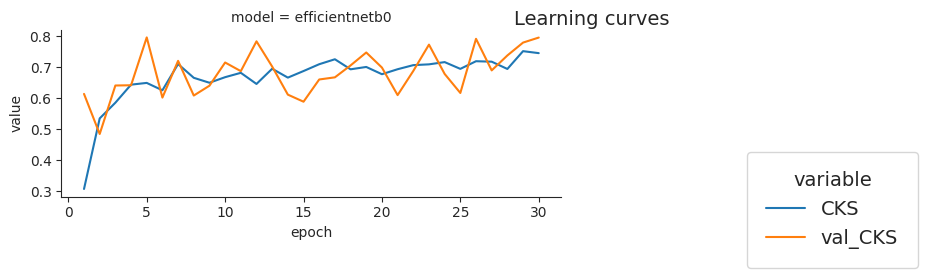

In [ ]:
epochs = list(range(1,EPOCHS+1))
full_cks_history = []
for model, history in histories.items():
    data = {}
    data['epoch'] = epochs
    data['model'] = [model]*EPOCHS
    data['CKS'] = history['CKS']
    data['val_CKS'] = history['val_CKS']
    full_cks_history.append(pd.DataFrame.from_dict(data))
full_cks_history_df = pd.concat(full_cks_history)

sns.set_style('ticks')
rp = sns.relplot(
    data=pd.melt(full_cks_history_df,['epoch','model']),
    x="epoch",
    y="value",
    hue="variable",
    col="model",
    col_wrap=2,
    height=2.5,
    aspect=2.2,
    kind="line"
)
rp.fig.suptitle('Learning curves', fontsize=14)
rp.fig.subplots_adjust(top=0.9)
sns.move_legend(rp,
                'center',
                bbox_to_anchor=(.7, .18),
                fontsize=14,
                title_fontsize=14,
                frameon=True,
                borderpad=1)